In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import configparser
import os.path
from os import path
from importlib import reload

WANDB_enable = False
creds_path_ar = ["../credentials.ini","credentials.colab.ini"]
PATH_ROOT = ""
PATH_DATA = ""

for creds_path in creds_path_ar:
    if path.exists(creds_path):
        config_parser = configparser.ConfigParser()
        config_parser.read(creds_path)
        PATH_ROOT = config_parser['MAIN']["PATH_ROOT"]
        PATH_DATA = config_parser['MAIN']["PATH_DATA"]
        WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
        ENV = config_parser['MAIN']["ENV"]
        break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)

In [ ]:
cd {PATH_ROOT}

In [ ]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.utils import experiment_utils as utils
from src.utils import boilerplate

from src.model_arch import arch_setup
from src.model_arch import base_base_model
from src.model_arch import alex_model

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [ ]:
train_x, train_y, val_x, val_y = boilerplate.classic_trainval(PATH_ROOT,PATH_DATA)

In [ ]:
train_set = arch_setup.DS(train_x,train_y)
val_set= arch_setup.DS(val_x,val_y)

train_loader=DataLoader(dataset= train_set, batch_size = 16, shuffle = True, num_workers = 2)
val_loader=DataLoader(dataset= val_set, batch_size = 16, shuffle = True, num_workers = 2)

In [78]:
model= alex_model.alex_mdf_s_model()
# model.apply(init_weights)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
model

alex_mdf_s_model(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (avg

In [77]:
arch_setup.train_epochs(train_loader,val_loader,model,criterion,optimizer,num_epochs= 10,device=device,train_y=train_y,val_y=val_y)

started training epoch no. 1


RuntimeError: size mismatch, m1: [16 x 4608], m2: [9216 x 4096] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41

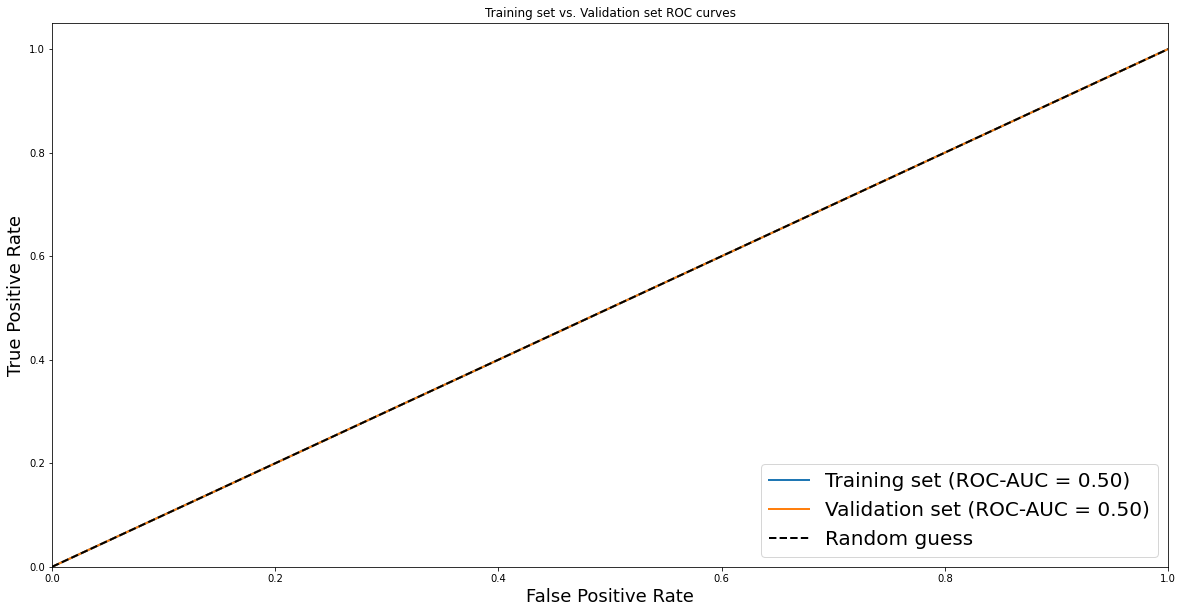

In [54]:
pred = [arch_setup.thresh(model(torch.from_numpy(train_x).type(torch.float32)).detach().cpu()), \
        arch_setup.thresh(model(torch.from_numpy(val_x).type(torch.float32)).detach().cpu())]
actual = [train_y, val_y]
utils.stats(pred, actual)